In [ ]:
# THE RASTERIZER MAKES NO SENSE AT THE MOMENT
# TOO SLOW IN PYTHON AND NOT REALLY A PROJECT THAT CAN BE DONE IN A SMALL JUPYTER NOTEBOOK

In [26]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [171]:
def load_mesh(filepath):
    
    content = None
    vertices = []
    triangles = []
    
    with open(filepath) as f:
        content = f.read()
    f.close()
    
    lines = content.split("\n")
    
    for line in lines:
        line_elems = line.split(" ")
        
        nums = line_elems[1:]
        
        if line_elems[0] == "v":
            # wandle direkt in projektive koordinaten um
            vertices.append([float(num) for num in nums])
            
        elif line_elems[0] == "f":
            # werden von 1 indexiert, aber wir bzw. plot_trisurf indexiert von 0
            triangles.append([int(num) - 1 for num in nums])
        
    return {"vertices": np.array(vertices), "triangles": np.array(triangles)}

In [172]:
def translation_matrix(dx, dy, dz):
    # 4x4 matrix da projektive koordinaten
    matrix = np.identity(4)
    matrix[:3, 3] = [dx, dy, dz]
    return matrix

In [173]:
# matrix = 4x4, alle vertices = 4x1
def transform_vertices(matrix, vertices):
    transformed_vertices = np.zeros(vertices.shape)
    
    for i, vertex in enumerate(vertices):
        vertex = vertex.reshape((3, 1))
        vertex = np.vstack([vertex, 1])
        transformed_vertex = np.matmul(matrix, vertex.reshape((4, 1)))
        transformed_vertices[i] = transformed_vertex[:3].flatten()
        
    return transformed_vertices

In [174]:
def transform_scene(matrix, meshes, lights):
    
    for mesh in meshes:
        mesh["vertices"] = transform_vertices(matrix, mesh["vertices"])

In [175]:
camera = {"focal_length": 1, "model_view_matrix": translation_matrix(0, -1.5, -4.5),
          "near": 1, "far": 10, "aspect": 16.0 / 9.0
         }

In [176]:
def plot_camera(ax, camera, color="red"):
    
    f = camera["focal_length"]
    
    camera_points = np.array([
        [-1, 1, -f],
        [1, 1, -f],
        [1, -1, -f],
        [-1, -1, -f]])
    
    o = np.array([0, 0, 0])
    
    for camera_point in camera_points:
        comb = np.array([o, camera_point])
        ax.plot(comb[:, 0], comb[:, 2], comb[:, 1] ,c=color)
    
    round_trip = np.vstack([camera_points, camera_points[0]])
    ax.plot(round_trip[:, 0], round_trip[:, 2], round_trip[:, 1], c=color)
    ax.scatter(camera_points[:, 0], camera_points[:, 2], camera_points[:, 1], c=color)

In [177]:
def plot_scene(meshes, camera, lights):
    
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    
    # transformiere szene
    transform_scene(camera["model_view_matrix"], meshes, lights)
    
    for mesh in meshes:
        vertices = mesh["vertices"]
        xs = vertices[:, 0]
        ys = vertices[:, 1]
        zs = vertices[:, 2]

        # gleiche die achsen der open gl definition an
        ax.plot_trisurf(xs, zs, ys, triangles=mesh["triangles"])
        
    for light in lights:
        pos = light["position"]
        ax.scatter(pos[0], pos[2], pos[1], c="yellow", edgecolors=[0, 0, 0], marker="*", sizes=[60])
    
    plot_camera(ax, camera)

    ax.set_xlabel("x")
    ax.set_ylabel("z")
    ax.set_zlabel("y")
    plt.show()

<IPython.core.display.Javascript object>


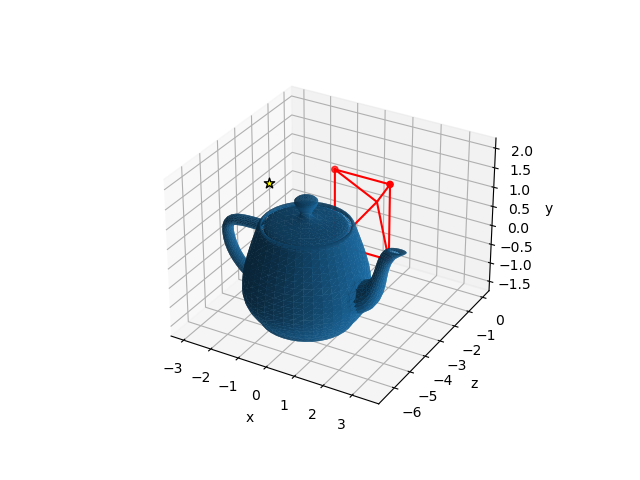

In [187]:
teapot = load_mesh("teapot.obj")

light = {"position": np.array([-1, 2, -5]),
        "I_a": np.array([1.0, 1.0, 1.0]),
        "I_d": np.array([1.0, 1.0, 1.0]),
        "I_s": np.array([1.0, 1.0, 1.0])}

plot_scene([teapot], camera, [light])

In [188]:
def get_projection_matrix(camera):
    
    f = camera["focal_length"]
    aspect = camera["aspect"]
    near = camera["near"]
    far = camera["far"]
    
    proj_matrix = [
        [f/aspect, 0, 0, 0],
        [0, f, 0, 0],
        [0, 0, (near + far) / (near - far), 2*near*far / (near-far)],
        [0, 0, -1, 0]]
    
    return np.array(proj_matrix)

In [189]:
def to_4x1(vertex_as_row):
    vertex = vertex_as_row.reshape((3, 1))
    vertex = np.vstack([vertex, 1])
    return vertex

In [190]:
def get_pixel_indices(vertex, proj_matrix, imag_matrix, width, height):
    vertex = to_4x1(vertex)
    
    vertex_clip = np.matmul(proj_matrix, vertex)
    vertex_ndc = vertex_clip / vertex_clip[3]
    vertex_proj = np.matmul(imag_matrix, vertex_ndc)
    
    x = width - vertex_proj[0]
    y = height - vertex_proj[1]
    z = vertex_proj[2]
    
    return np.array([x, y, z])

In [191]:
# A, B, C sind [pixel x, pixel y] in 2x1
# P = [pixel x, pixel y] in 2x1
# alles sind np arrays
def find_barycentric(P, A, B, C):
    
    A = np.vstack([A, 0]).flatten()
    B = np.vstack([B, 0]).flatten()
    C = np.vstack([C, 0]).flatten()
    P = np.vstack([P, 0]).flatten()
    
    area_total = np.linalg.norm(np.cross(B-A, C-A))
    area_opposite_c = np.linalg.norm(np.cross(B-A, P-A))
    area_opposite_b = np.linalg.norm(np.cross(P-A, C-A))
    area_opposite_a = np.linalg.norm(np.cross(B-P, C-P))
    
    alpha = area_opposite_a /  area_total
    beta = area_opposite_b /  area_total
    gamma = area_opposite_c /  area_total
    
    return alpha, beta, gamma

In [192]:
# vertices wurden schon transformiert
def get_image_of_scene(meshes, camera, lights):
    
    transform_scene(camera["model_view_matrix"], meshes, lights)
    
    width = 426
    height = 240
    
    # rbg image
    image = np.zeros((height, width, 3))
    depth_buffer = np.ones((height, width)) * camera["far"]
    
    proj_matrix = get_projection_matrix(camera)
    imag_matrix = np.array([[width, 0, 0, width/2], [0, height, 0, height/2], [0, 0, 1, 0], [0, 0, 0, 1]])
    
    dotSize = 1
    triangles_finished = 0
    
    for mesh in meshes:
        
        vertices = mesh["vertices"]
        
        for triangle in mesh["triangles"]:
            v0 = vertices[triangle[0]]          
            v1 = vertices[triangle[1]]
            v2 = vertices[triangle[2]]
            
            # [x, y, z] where x and y are screen coordinates and z is the depth value after projection
            v0_s = get_pixel_indices(v0, proj_matrix, imag_matrix, width, height)
            v1_s = get_pixel_indices(v1, proj_matrix, imag_matrix, width, height)
            v2_s = get_pixel_indices(v2, proj_matrix, imag_matrix, width, height)
            
            proj_pixels = np.array([v0_s, v1_s, v2_s])
            proj_min = np.min(proj_pixels, axis=0)[:2]
            proj_max = np.max(proj_pixels, axis=0)[:2]
            
            for x in range(int(proj_min[0]), int(proj_max[0])):
                for y in range(int(proj_min[1]), int(proj_max[1])):
                    
                    P = np.array([x, y]).reshape((-1, 1))
                    A = v0_s.reshape((-1, 1))[:2]
                    B = v1_s.reshape((-1, 1))[:2]
                    C = v2_s.reshape((-1, 1))[:2]
                    
                    alpha, beta, gamma = find_barycentric(P, A, B, C)
                    
                    # perspective correct interpolation to get z value
                    z_inv = (alpha / v0_s[2]) + (beta / v1_s[2]) + (gamma / v2_s[2])
                    z = 1 / z_inv
                    
                    depth = -z
                    
                    # go back to 3d space
                    #v_p = np.array([(P[0] - width/2) / width, (P[1] - height/2) / height, -camera["focal_length"]])
                    #v_p *= z
                    
                    if depth >= depth_buffer[y, x]:
                        continue
                    
                    # material properties of the pot
                    K_a = [0.2, 0.1, 0]
                    K_d = [0.8, 0.4, 0]
                    K_s = [1.0, 1.0, 1.0]
                    
                    final_color = np.zeros(3)
                    surface_normal = np.cross(v1- v0, v2-v0)
                    surface_normal /= np.linalg.norm(surface_normal)
                    
                    
                    for light in lights:
                        final_color += light["I_a"] * K_a
                        
                        L = light["position"] - v0
                        L /= np.linalg.norm(L)
                        
                        coeff = np.clip(np.dot(surface_normal, L), 0, 1)
                        
                        final_color += coeff * light["I_d"] * K_d
                    
                    
                    if 0 <= alpha <= 1 and 0 <= beta <= 1 and 0 <= gamma <= 1:
                        image[y, x] = final_color
                        depth_buffer[y, x] = depth
                        
            triangles_finished += 1
            
            if(triangles_finished % 1000 == 0):
                print(triangles_finished / len(mesh["triangles"]), "% finished")
            
    
    # map depth buffer to [0, 1]
    max_depth = depth_buffer.max()
    min_depth = depth_buffer.min()
    
    depth_buffer = 1 - ((depth_buffer - min_depth) / (max_depth - min_depth))
    return image, depth_buffer

In [193]:
def show_image(image):
    fig = plt.figure()
    plt.title("Rasterized image")
    plt.imshow(image, cmap="gray", vmin=0, vmax=1)
    plt.show()

0.15822784810126583 % finished
0.31645569620253167 % finished
0.47468354430379744 % finished
0.6329113924050633 % finished
0.7911392405063291 % finished
0.9493670886075949 % finished


<IPython.core.display.Javascript object>


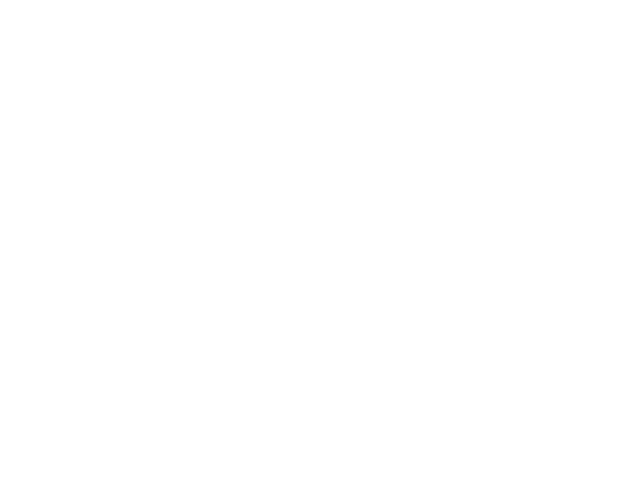

<IPython.core.display.Javascript object>


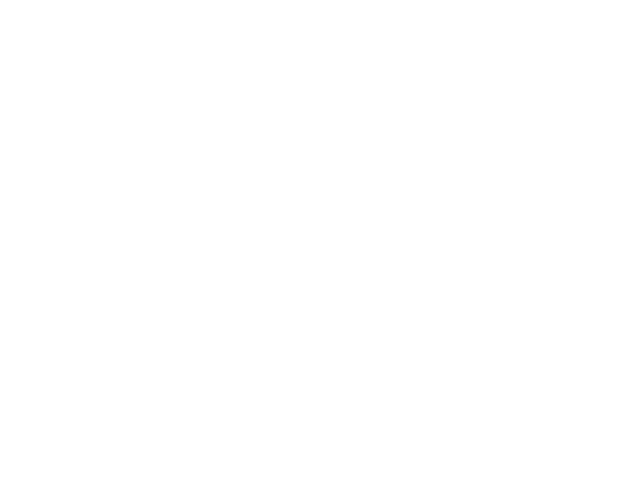

In [194]:
teapot = load_mesh("teapot.obj")
#7.19 s ± 7.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
image, depth_buffer = get_image_of_scene([teapot], camera, [light])
show_image(image)
show_image(depth_buffer)